# 4998 Applied Deep Learning Project
## Detect Cancer Metastases on Pathology Images

Jing Qian (jq2282)

# STEP 1. First glance of data and generate training images

## Step 1 is processed in GenerateTrain.ipynb.



In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
total_path = '/content/drive/My Drive/project-adl'

In [0]:
input_size = 299 # in corresponding level
tumor_check_size = 128 # in level 0 with the highest resolution

# STEP 2. MODELING

* Although transfer learning may be less effective than training a model from scratch , it is the best place to start.
* Choose a model previously trained on Imagenet. Use the techniques in Chapter 5 of Francois’s book to try transfer learning (add a single Dense layer on top of that model), and train it on your own data.
* Write a script that takes your trained model and a testing image, and outputs a heat map showing the cancerous regions.
* Design an evaluation metric, write a script to report your results

In [0]:
TARGET_SHAPE = 299
BATCH_SIZE = 32

## 2.0 Get Training Images

In [0]:
ilevel = 3
train_dir = 'drive/My Drive/project-adl/train_level%d'%ilevel

In [0]:
nclass=100

In [8]:
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## 2.1 Transfer learning

In [31]:
train_features = np.reshape(train_features, (nclass*2, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split = 0.2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 160 samples, validate on 40 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
160/160 [==============================] - 2s 11ms/sample - loss: 4.9592 - acc: 0.5562 - val_loss: 3.6585 - val_acc: 0.7500
Epoch 2/50
160/160 [==============================] - 0s 2ms/sample - loss: 3.5910 - acc: 0.7688 - val_loss: 3.2237 - val_acc: 0.8000
Epoch 3/50
160/160 [==============================] - 0s 2ms/sample - loss: 2.4609 - acc: 0.8375 - val_loss: 2.9460 - val_acc: 0.8000
Epoch 4/50
160/160 [==============================] - 0s 2ms/sample - loss: 1.7038 - acc: 0.8938 - val_loss: 2.7943 - val_acc: 0.8250
Epoch 5/50
160/160 [==============================] - 0s 2ms/sample - loss: 1.9266 - acc: 0.8750 - val_loss: 3.4157 - val_acc: 0.7750
Epoch 6/50
160/160 [==============================] - 0s 2ms/sample - loss: 1.9034 - acc: 0.8813 - val_loss: 3.5369 - val

### Save model

In [0]:
import pickle
import tensorflow as tf

pickle.dump(model, open("drive/My Drive/project-adl/model-lev%s-transfer"%slide_id, "wb"))

In [0]:
# Load the saved model
saved_model = pickle.load(open("drive/My Drive/project-adl/model-lev%s-transfer"%slide_id, "rb"))

## 2.2 Train from scratch

In [0]:
conv_base_2 = InceptionV3(weights=None,include_top=False, input_shape=(299,299,3))
#conv_base_2.summary()
datagen = ImageDataGenerator(rescale=1./255)

def extract_features_2(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048)) # get from conv_base.summary()
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_2.predict(inputs_batch)       
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features_2(train_dir, nclass*2)
print(train_labels)

FLATTENED_SHAPE = 8 * 8 * 2048

In [10]:
train_features = np.reshape(train_features, (nclass*2, FLATTENED_SHAPE))
EPOCHS = 50
model2 = Sequential()
model2.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split = 0.2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 160 samples, validate on 40 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
160/160 [==============================] - 1s 7ms/sample - loss: 0.7057 - acc: 0.4563 - val_loss: 0.6876 - val_acc: 0.5750
Epoch 2/50
160/160 [==============================] - 0s 2ms/sample - loss: 0.6940 - acc: 0.4938 - val_loss: 0.6950 - val_acc: 0.4250
Epoch 3/50
160/160 [==============================] - 0s 2ms/sample - loss: 0.6888 - acc: 0.5312 - val_loss: 0.6949 - val_acc: 0.4250
Epoch 4/50
160/160 [==============================] - 0s 2ms/sample - loss: 0.6867 - acc: 0.5250 - val_loss: 0.6949 - val_acc: 0.4250
Epoch 5/50
160/160 [==============================] - 0s 2ms/sample - loss: 0.6882 - acc: 0.5250 - val_loss: 0.6947 - val_acc: 0.4250
Epoch 6/50
160/160 [==============================] - 0s 2ms/sample - loss: 0.6840 - acc: 0.5813 - val_loss: 0.6913 - val_

### Save model

In [12]:
import pickle
pickle.dump(model2, open("drive/My Drive/project-adl/model-lev%s-scratch"%slide_id, "wb"))

NotImplementedError: ignored

In [0]:
# Load the saved model
saved_model_2 = pickle.load(open("drive/My Drive/project-adl/model-lev%s-scratch"%slide_id, "rb"))

## 2.3. Try Amal's model


In [0]:
import tensorflow.keras
from tensorflow.keras.applications.inception_v3 import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
conv_base = InceptionV3(weights='imagenet',include_top=False, input_shape=(299,299,3))
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
nclass = 100
ilevel = 3
train_dir = 'drive/My Drive/project-adl/train_level%d'%ilevel

datagen = ImageDataGenerator(rescale=1./255)

# data = np.zeros(shape=(nclass*2, 299, 299, 3)) # get from conv_base.summary()
# labels = np.zeros(shape=(nclass*2))
generator = datagen.flow_from_directory(
        train_dir,
        target_size=(input_size, input_size),
        batch_size=32,
        class_mode='binary')
model.fit_generator(generator, steps_per_epoch=(nclass*2)//32, epochs=50)

Found 200 images belonging to 2 classes.
Epoch 1/50
7/7 [==============================] - 7s 1s/step - loss: 7.5975 - acc: 0.5000
Epoch 2/50
7/7 [==============================] - 3s 450ms/step - loss: 8.1580 - acc: 0.5000
Epoch 3/50
7/7 [==============================] - 3s 449ms/step - loss: 7.9712 - acc: 0.5000
Epoch 4/50
7/7 [==============================] - 3s 450ms/step - loss: 8.1580 - acc: 0.5000
Epoch 5/50
7/7 [==============================] - 3s 452ms/step - loss: 7.9712 - acc: 0.5000
Epoch 6/50
7/7 [==============================] - 3s 452ms/step - loss: 7.4107 - acc: 0.5000
Epoch 7/50
7/7 [==============================] - 3s 456ms/step - loss: 7.7991 - acc: 0.5100
Epoch 8/50
7/7 [==============================] - 3s 464ms/step - loss: 6.1496 - acc: 0.5950
Epoch 9/50
7/7 [==============================] - 3s 486ms/step - loss: 2.1290 - acc: 0.6750
Epoch 10/50
7/7 [==============================] - 3s 468ms/step - loss: 1.2744 - acc: 0.8000
Epoch 11/50
7/7 [==============

## Test the model with one test slide

In [0]:
patch_ij = read_slide(slide,
                          x = 20000,
                          y = 20000,
                          level = 3,
                          width = input_size,
                          height = input_size)

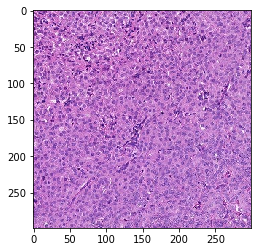

In [21]:
import matplotlib.pyplot as plt
plt.imshow(patch_ij)

In [0]:
patch_ij = (patch_ij/255.).reshape(-1,299,299,3)
a=model.predict(patch_ij)[:]

(1, 1)

In [0]:
# Abstract pathces from level 3, stride 128 to get continuous label for 128*128 center region.
# Like in training, cut the 10% border but without grayscale filters.
# slide_image is 3d, [height, width, channel]
stride = 128
bound = 149 # (299-1)//2
width = slide.level_dimensions[ilevel][0]
height = slide.level_dimensions[ilevel][1]
nx = (int(width*0.9)-int(width*0.1))//stride + 1
ny = (int(height*0.9)-int(height*0.1))//stride + 1
pred = np.zeros((ny, nx))
test_label = np.zeros((ny, nx))
for i in range(nx):
  for j in range(ny):
    patch_ij = read_slide(slide,
                          x = int(0.1*width+stride*i-bound)*down_factor[ilevel],
                          y = int(0.1*height+stride*j-bound)*down_factor[ilevel],
                          level = ilevel,
                          width = input_size,
                          height = input_size)
    patch_ij = (patch_ij/255.).reshape(-1,299,299,3)
    ipred = model.predict(patch_ij)[:]
    pred[j][i] = ipred
    center = read_slide(tumor_mask,
                         x = int(0.1*width+stride*i-63)*down_factor[ilevel], 
                         y = int(0.1*height+stride*j-63)*down_factor[ilevel],
                         level = ilevel,
                         width = tumor_check_size,
                         height = tumor_check_size)[:,:,0]
    ilabel = 0
    if np.any(center) == 1: ilabel = 1
    test_label[j][i] = ilabel

Text(0.5, 1.0, 'tumor mask')

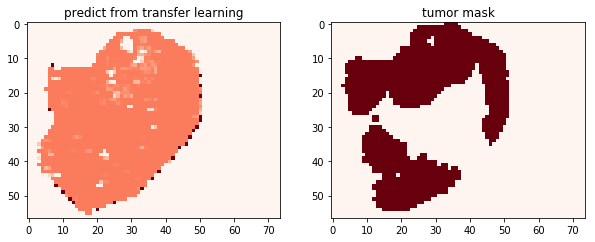

In [53]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(pred, cmap='Reds')
plt.title('predict from transfer learning')
plt.subplot(1,2,2)
plt.imshow(test_label, cmap='Reds')
plt.title('tumor mask')

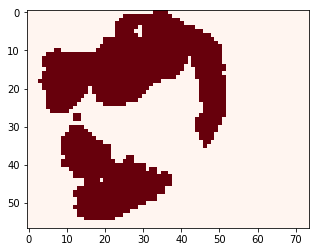

In [50]:
plt.imshow(test_label, cmap='Reds')

# STEP 3. TEST!

### General Params

In [39]:
input_size = 299
tumor_check_size = 128
bound = (input_size - 1)/2

down_factor = dict()
for i in range(8):
  down_factor[i] = 2**i
print(down_factor)

{0: 1, 1: 2, 2: 4, 3: 8, 4: 16, 5: 32, 6: 64, 7: 128}


### Start with one slide

## 3.1. Generate testing image

In [0]:
# Paras
ilevel = 3
slide_id = '110'

In [13]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    #print('1')
    im = slide.read_region((x,y), level, (width, height))
    #print('2')
    im = im.convert('RGB') # drop the alpha channel
    #print('3')
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [16]:
slide_path = os.path.join(total_path,'slides/tumor_%s.tif' %slide_id)
tumor_mask_path = os.path.join(total_path,'slides/tumor_%s_mask.tif' %slide_id)

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    if i < 8:
      assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/drive/My Drive/project-adl/slides/tumor_110.tif with width: 94208, height: 71680
Read tumor mask from /content/drive/My Drive/project-adl/slides/tumor_110_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, dimensions: (11776, 8960) downsample factor 8
Level 4, dimensions: (5888, 4480) downsample factor 16
Level 5, dimensions: (2944, 2240) downsample factor 32
Level 6, dimensions: (1472, 1120) downsample factor 64
Level 7, dimensions: (736, 560) downsample factor 128
Level 8, dimensions: (368, 280) downsample factor 256


In [0]:
slide_image = read_slide(slide, 
                       x=0, 
                       y=0, 
                       level=ilevel, 
                       width=slide.level_dimensions[ilevel][0], 
                       height=slide.level_dimensions[ilevel][1])

In [0]:
# Abstract pathces from level 3, stride 128 to get continuous label for 128*128 center region.
# Like in training, cut the 10% border but without grayscale filters.
# slide_image is 3d, [height, width, channel]
test_center = []
test_patches = []
stride = 128
bound = 149 # (299-1)//2
width = slide.level_dimensions[ilevel][0]
height = slide.level_dimensions[ilevel][1]
nx = (int(width*0.9)-int(width*0.1))//stride + 1
ny = (int(height*0.9)-int(height*0.1))//stride + 1
for i in range(nx):
  for j in range(ny):
    patch_ij = read_slide(slide,
                          x = int(0.1*width+stride*i-bound)*down_factor[ilevel],
                          y = int(0.1*height+stride*j-bound)*down_factor[ilevel],
                          level = ilevel,
                          width = input_size,
                          height = input_size)
    test_patches.append(patch_ij)
    test_center.append((int(0.1*width+stride*i-63), int(0.1*height+stride*j-63)))

# Test 

## 3.2. Save the testing images

In [0]:
import shutil
test_dir = 'drive/My Drive/project-adl/test_level%d' %ilevel
if not os.path.exists(test_dir):
  os.mkdir(test_dir)

(4218, 299, 299, 3)


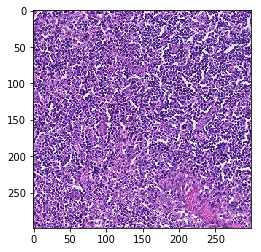

In [19]:
print(np.shape(test_patches))
plt.imshow(test_patches[1000])
from matplotlib.image import imsave
for i in range(nx):
  for j in range(ny):
    filename = os.path.join(test_dir, 'tumor_%s_cenx%d_ceny%d.png' 
                            %(slide_id, int(0.1*width+stride*i-63), int(0.1*height+stride*j-63)))
    imsave(filename, test_patches[i*ny+j])

In [81]:
def extract_features_predict(directory, sample_count,BATCH_SIZE=1):
    features = np.zeros(shape=(sample_count, 8, 8, 2048)) # get from conv_base.summary()
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_2.predict(inputs_batch)       
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features
test_features = extract_features_predict(test_dir, 4218, BATCH_SIZE = 32)


Found 4218 images belonging to 1 classes.


In [0]:
test_features = np.reshape(test_features, (4218, FLATTENED_SHAPE))
prob = model2.predict(test_features,batch_size = 32)

In [79]:
prob

array([[0.12252302],
       [0.13299099],
       [0.6187222 ],
       [0.12353332],
       [0.5984149 ],
       [0.58575785],
       [0.1225559 ],
       [0.5879276 ],
       [0.1217115 ],
       [0.12233924]], dtype=float32)

In [0]:
width = 11776
height = 8960
stride = 128
nx = (int(width*0.9)-int(width*0.1))//stride + 1
ny = (int(height*0.9)-int(height*0.1))//stride + 1
# X, Y = [],[]
# for i in range(nx):
#     ix = int(0.1*width+stride*i-63)
#     X.append(ix)    
# for j in range(ny):
#     jy = int(0.1*height+stride*j-63)
#     Y.append(jy)

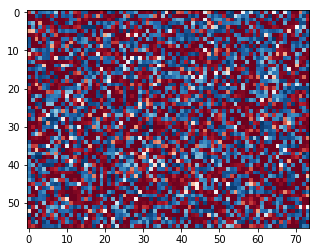

In [83]:
p = np.zeros((ny, nx))
for i in range(nx):
  for j in range(ny):
    p[j][i] = prob[i*ny+j]
plt.imshow(p, cmap='RdBu')

## 3.2. Compare with the true labels

In [0]:
mask_image = read_slide(tumor_mask, 
                      x=0, 
                      y=0, 
                      level=7, 
                      width=slide.level_dimensions[7][0], 
                      height=slide.level_dimensions[7][1])[:,:,0]

NameError: ignored